<h1 style="text-align:center;">Stochastic Lotka–Volterra</h1>
<h3 style="text-align:center;">Stochastic Processes and Simulations in Natural Sciences (30561)</h3>
<h5 style="text-align:center;">Stoica Alexandru(3260547)   Dontu Catalin(3244174)   Antonescu Victor-Gabriel(3245562)</h3>

### Table of Contents:
1. Introduction
2. Libraries
3. The Deterministic Approach - ODE
4. Limitations of the Deterministic Approach
5. The Stochastic Approach - Gillespie Simulation
6. Performance improvement for the Stohcastic Approach
7. Conclusions

### 1. Introduction

The Lotka-Voltera Predator-Pray Model is represented by 2 first-order nonlinear differential equations. It is often used in biological systems in which 2 species interact. The population of the species evolves through time according to the following system:

$$
\begin{aligned}
\frac{dx(t)}{dt} &= \alpha x(t) - \beta x(t)y(t)\\[6pt]
\frac{dy(t)}{dt} &= -\gamma y(t) + \delta x(t)y(t) 
\end{aligned}
$$

$$
\alpha, \beta, \gamma, \delta \in \mathbb{R}_{+} \setminus \{0\}
$$

where  
- $x(t)$: prey population density at time t 
- $y(t)$: predator population density at time t 
- $\alpha$: prey's growth rate per capita
- $\beta$: effect of presence of predators on the prey's death rate
- $\gamma$: predator's death rate per capita
- $\delta$: effect of presence of pray on the predator's growth rate
- $t$: time

The deterministic model makes several **assumptions** about the environment and biology of the predator and prey population:

- **Unlimited Food Supply**: The prey population has an unlimited food supply at all times.
- **Relation Food Supply-Prey Population**: The food supply of the predator population depends entierly on the size of the prey population.
- **Continuous Population Growth**: The rate of change of population is proportional to its size.
- **Constant Environment**: The environment does not change during the process in favor of any species.
- **Continuous Predation**: Predators have limitless appettite.
- **Single Variables**: Populations are described by a single variable.

### 2. Libraries

We used ipywidgets library to make an interactive dashboard for the Deterministic Version of Lotka-Volterra model where we can observe the phase space and the evolution of the populations over time with different parameters.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

from math import log

from ipywidgets import HTML, FloatSlider, Button, VBox, HBox, Output
import ipywidgets as widgets

import random
random.seed(42)

### 3. The Deterministic Approach – ODE

In this section we solve the **classical Lotka–Volterra Predator–Prey model** using ordinary differential equations (ODEs).
The model describes the interaction between a prey population and a predator population, as already mentioned in the introduction section.

Our goals in this section are:
- to **define the ODE system** mathematically,
- to **solve it numerically** using `scipy.integrate.odeint`,
- to **visualize the dynamics** of prey and predators over time,
- to **plot the phase portrait** (predator vs. prey),
- and to explore how the dynamics change interactively by varying the parameters with sliders.

In [2]:
# Store initial values for reset
INITIAL_VALUES = {
    'b': 0.5,
    'm': 0.5,
    'r': 0.02,
    'a': 0.01,
    'H0': 40,
    'P0': 9,
    't_max': 200 
}

EXTINCTION_THRESHOLD = 0.1

- `INITIAL_VALUES` stores default values for:
  - `b`: baseline rate at which prey reproduce.
  - `m`: baseline rate at which predators die in the absence of prey.
  - `r`: strength of predation (how quickly prey are removed per predator).
  - `a`: efficiency with which predators gain new individuals by consuming prey.
  - `H0` and `P0`: initial population sizes of prey and predators at time `t = 0`.
  - `t_max`: length of the simulated time interval.
- `EXTINCTION_THRESHOLD` defines a small population level below which a species is considered effectively extinct.
- Saving these values in a dictionary makes it easy to **reset the sliders** and also pass parameters into functions using keyword arguments.

In [3]:
# Model

def lotka_volterra(state, t, b, m, r, a):

    """
    Lotka-Volterra equations

    P = Predators, H = Prey

    Parameters:
    b: Birth rate of prey
    m: Death rate of predators
    r: Death rate of prey per predator
    a: Birth rate of predators per prey
    """

    H, P = state
    dH_dt = b*H - r*H*P
    dP_dt = -m*P + a*H*P
    return [dH_dt, dP_dt]

# Simulation

def simulate_lv(b, m, r, a, H0, P0, t_max, n_points=1000):

    """
    Solve the LV system and return t, H, P plus equilibrium values.
    """

    t = np.linspace(0, t_max, n_points)
    initial_state = [H0, P0]
    
    solution = odeint(lotka_volterra, initial_state, t, args=(b, m, r, a))
    H = solution[:, 0]
    P = solution[:, 1]
    
    # Equilibria 
    H_eq = m / a if a != 0 else 0
    P_eq = b / r if r != 0 else 0
    
    return t, H, P, H_eq, P_eq

- `lotka_volterra(state, t, b, m, r, a)` encodes the **deterministic predator–prey model**:
  - `state` contains the current populations `(H, P)`.
  - `dH_dt = b*H - r*H*P`:
    - `b*H` is the natural growth of the prey.
    - `r*H*P` is the loss of prey due to encounters with predators.
  - `dP_dt = -m*P + a*H*P`:
    - `-m*P` is the natural death of predators in the absence of prey.
    - `a*H*P` is the gain of predators due to successful predation.
- `simulate_lv(...)`:
  - Builds a time grid `t` from `0` to `t_max` with `n_points` steps.
  - Sets the initial state `[H0, P0]` and calls `odeint` to integrate the ODE system over time.
  - Extracts the prey trajectory `H(t)` and predator trajectory `P(t)` from the solution array.
  - Computes the **equilibrium point** \((H^*, P^*)\) where both derivatives are zero:
    - \(H^* = m/a\) (if `a ≠ 0`)
    - \(P^* = b/r\) (if `r ≠ 0`)
  - Returns all data needed for plotting: `t`, `H`, `P`, and the equilibrium values `H_eq`, `P_eq`.

In [4]:
# Plotting

def extinction_message(H, P, threshold=EXTINCTION_THRESHOLD):
    H_extinct = np.any(H < threshold)
    P_extinct = np.any(P < threshold)

    if H_extinct and P_extinct:
        return "Both species go extinct"
    elif H_extinct:
        return "Prey go extinct => Predators starve"
    elif P_extinct:
        return "Predators go extinct => Prey explode"
    return ""


def plot_lv(t, H, P, H_eq, P_eq, params, initial_state):

    """
    Draw the time series and phase-space plots.
    params: dict with keys 'b','m','r','a'
    initial_state: (H0, P0)
    """

    b, m, r, a = params['b'], params['m'], params['r'], params['a']
    H0, P0 = initial_state

    msg = extinction_message(H, P)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Time series
    ax1.plot(t, H, label='Prey (H)', linewidth=2)
    ax1.plot(t, P, label='Predators (P)', linewidth=2)

    if a > 0 and m > 0:
        ax1.axhline(y=H_eq, linestyle='--', alpha=0.5,
                    label=f'Prey eq: {H_eq:.1f}')
    if r > 0 and b > 0:
        ax1.axhline(y=P_eq, linestyle='--', alpha=0.5,
                    label=f'Pred eq: {P_eq:.1f}')

    title = 'Population Dynamics Over Time'
    if msg:
        title += f'\n{msg}'
    ax1.set_title(title)
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Population')
    ax1.set_ylim(bottom=0)
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # Phase-space
    ax2.plot(H, P, linewidth=2)
    ax2.plot(H0, P0, 'ko', markersize=10, label=f'Initial ({H0:.0f}, {P0:.0f})')

    if a > 0 and m > 0 and r > 0 and b > 0:
        ax2.plot(H_eq, P_eq, 'ro', markersize=8,
                 label=f'Equilibrium ({H_eq:.1f}, {P_eq:.1f})')
        ax2.axvline(x=H_eq, linestyle=':', alpha=0.5)
        ax2.axhline(y=P_eq, linestyle=':', alpha=0.5)

    ax2.set_title('Phase Space (Predator vs Prey)')
    ax2.set_xlabel('Prey (H)')
    ax2.set_ylabel('Predators (P)')
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    plt.tight_layout()
    plt.show()

- `extinction_message(H, P, threshold)`:
  - Checks whether the prey or predator populations ever fall below the extinction threshold.
  - Returns a short qualitative message describing the scenario.
  
- `plot_lv(t, H, P, H_eq, P_eq, params, initial_state)`:
  - Creates a **time-series plot** of `H(t)` (prey) and `P(t)` (predators).
  - Draws **horizontal lines** at the equilibrium populations `H_eq` and `P_eq` when they are defined.
  - Displays an extinction message above the plot if extinction occurs.
  - Creates a **phase-space plot** (predators vs. prey) showing the trajectory in the `(H, P)` plane.
  - Marks the equilibrium point \((H^*, P^*)\) and adds dotted reference lines through it.
  - Adds titles, labels, legend, and grid for readability, then calls `plt.show()` to render the figure.

In [5]:
# Widget Construction for Visualization

# Sliders
b_slider = FloatSlider(min=0.0, max=2.0, step=0.1,
                       value=INITIAL_VALUES['b'],
                       description='b (birth)', continuous_update=True)

m_slider = FloatSlider(min=0.0, max=2.0, step=0.1,
                       value=INITIAL_VALUES['m'],
                       description='m (death)', continuous_update=True)

r_slider = FloatSlider(min=0.0, max=0.1, step=0.005,
                       value=INITIAL_VALUES['r'],
                       description='r (death)', continuous_update=True)

a_slider = FloatSlider(min=0.0, max=0.1, step=0.005,
                       value=INITIAL_VALUES['a'],
                       description='a (birth)', continuous_update=True)

H0_slider = FloatSlider(min=0, max=100, step=5,
                        value=INITIAL_VALUES['H0'],
                        description='H0 (initial)', continuous_update=True)

P0_slider = FloatSlider(min=0, max=100, step=2,
                        value=INITIAL_VALUES['P0'],
                        description='P0 (initial)', continuous_update=True)

t_max_slider = FloatSlider(min=50, max=500, step=50,
                           value=INITIAL_VALUES['t_max'],
                           description='Time span', continuous_update=True)

# Buttons
only_prey_btn = Button(description="Only Prey Case",
                       button_style='info',
                       tooltip='Set parameters for prey-only scenario')

only_predators_btn = Button(description="Only Predators Case",
                            button_style='info',
                            tooltip='Set parameters for predator-only scenario')

equilibrium_btn = Button(description="Equilibrium Case",
                         button_style='success',
                         tooltip='Set classic parameters with equilibrium start')

reset_all_btn = Button(description="Reset All Parameters",
                       button_style='warning',
                       tooltip='Reset ALL parameters to initial values')

# Output area
output = Output()

prey_title = HTML("<b>Prey parameters:</b>")
pred_title = HTML("<b>Predator parameters:</b>")

# Layout
left_column = VBox(
    [prey_title, b_slider, r_slider, H0_slider],
    layout=widgets.Layout(align_items='center')
)

right_column = VBox(
    [pred_title, m_slider, a_slider, P0_slider],
    layout=widgets.Layout(align_items='center')
)

scenario_button_row = HBox(
    [only_prey_btn, equilibrium_btn, only_predators_btn],
    layout=widgets.Layout(justify_content='center', margin='5px 0')
)

utility_button_row = HBox(
    [reset_all_btn],
    layout=widgets.Layout(justify_content='center', margin='5px 0')
)

top_row = HBox(
    [left_column, right_column],
    layout=widgets.Layout(justify_content='center')
)

bottom_row = VBox(
    [scenario_button_row, utility_button_row, t_max_slider],
    layout=widgets.Layout(align_items='center')
)

dashboard_title = widgets.HTML(
    "<h2 style='text-align:center; margin-bottom:10px;'>Visualization Dashboard</h2>"
)

ui = VBox([dashboard_title, top_row, bottom_row])

- Sliders:
  - One slider for each model parameter (`b`, `m`, `r`, `a`) and each initial condition (`H0`, `P0`, `t_max`).
  - The sliders are initialized using the values in `INITIAL_VALUES`.
  - Moving a slider will update the corresponding parameter in the simulation.
- Buttons:
  - Provide quick presets such as “Only prey”, “Only predators”, “Equilibrium”, and “Reset”.
  - When clicked, they overwrite the slider values with specific parameter combinations (handled in the callbacks).
- Layout (`VBox`, `HBox`):
  - `VBox` stacks sliders and buttons vertically in a control panel.
  - `HBox` places the control panel next to the plotting `output` area for a clean, interactive interface.

In [6]:
# Callbacks

def read_params_from_sliders():
    return dict(
        b=b_slider.value,
        m=m_slider.value,
        r=r_slider.value,
        a=a_slider.value,
        H0=H0_slider.value,
        P0=P0_slider.value,
        t_max=t_max_slider.value,
    )

def plot_lotka_volterra(b, m, r, a, H0, P0, t_max):

    """
    Wrapper for interactive_output
    """
    
    output.clear_output(wait=True)
    with output:
        t, H, P, H_eq, P_eq = simulate_lv(b, m, r, a, H0, P0, t_max)
        params = {'b': b, 'm': m, 'r': r, 'a': a}
        plot_lv(t, H, P, H_eq, P_eq, params, (H0, P0))


# Button actions
def only_prey_case(_):
    m_slider.value = 1.0
    a_slider.value = 0.0
    r_slider.value = 0.0
    P0_slider.value = 0.0

def only_predators_case(_):
    b_slider.value = 0.0
    H0_slider.value = 0.0
    r_slider.value = 0.0

def equilibrium_case(_):
    b_slider.value = 0.5
    m_slider.value = 0.5
    r_slider.value = 0.02
    a_slider.value = 0.01

    H_eq = m_slider.value / a_slider.value
    P_eq = b_slider.value / r_slider.value

    H0_slider.value = H_eq
    P0_slider.value = P_eq

def reset_initial_numbers(_):
    for k, v in INITIAL_VALUES.items():
        if k == 'b':   b_slider.value = v
        elif k == 'm': m_slider.value = v
        elif k == 'r': r_slider.value = v
        elif k == 'a': a_slider.value = v
        elif k == 'H0': H0_slider.value = v
        elif k == 'P0': P0_slider.value = v
        elif k == 't_max': t_max_slider.value = v

# Link buttons
only_prey_btn.on_click(only_prey_case)
only_predators_btn.on_click(only_predators_case)
equilibrium_btn.on_click(equilibrium_case)
reset_all_btn.on_click(reset_initial_numbers)

- `read_params_from_sliders()`:
  - Reads the current values from all sliders and packs them into a dictionary.
  - This is useful for passing the current slider settings to the simulation and plotting functions.
- `plot_lotka_volterra(...)`:
  - Acts as a **wrapper** between the sliders and the plotting code.
  - Calls `simulate_lv` with the current parameter values to get `t`, `H`, `P`, and equilibrium values.
  - Clears the previous plot in `output` and calls `plot_lv` to draw the new figure.
- Button callbacks:
  - Each button click callback updates selected sliders to a predefined scenario.
  - After sliders change, the linked plot is automatically updated.

In [7]:
# Initial Display

display(ui)

out = widgets.interactive_output(
    
    plot_lotka_volterra,
    {
        'b': b_slider,
        'm': m_slider,
        'r': r_slider,
        'a': a_slider,
        'H0': H0_slider,
        'P0': P0_slider,
        't_max': t_max_slider
    }
)

display(output)

# Initial plot
plot_lotka_volterra(**INITIAL_VALUES)

Output()

The classical Lotka–Volterra system gives us a clean and mathematically elegant description of predator–prey interactions. It reveals important qualitative features such as:

- closed orbits representing population cycles,
- a neutrally stable equilibrium point,
- the dependence of oscillation shape on the initial conditions.

### 4. Limitations of the Deterministic Approach

The previous deterministic formulation has some **significant limitations**:

1. **Predictability:**  
   The ODE assumes that populations change smoothly and continuously, ignoring the randomness present in real ecological systems.

2. **No population discreteness:**  
   Prey and predators are treated as continuous variables, even though they are composed of individual organisms.

3. **No extinction events:**  
   The deterministic model never allows populations to reach true extinction, even when numbers drop very.

4. **No environmental variability:**  
   Real ecosystems experience fluctuations in resources, temperature, reproduction, and death rates. These cannot be captured in a purely deterministic framework.

5. **Conserved cycles (no damping or spiraling):**  
   The classical model predicts perfectly repeated cycles. Real ecosystems rarely follow such ideal periodic behavior.

#### Example 1 – No discreteness or extinction

If we start with very small populations, the deterministic ODE model still
treats prey and predators as continuous variables. The trajectories can get
arbitrarily close to zero, but never actually reach extinction.

In a real
system with individual organisms, the population would jump from 1 to 0 in a
single event (this representing true extintion).

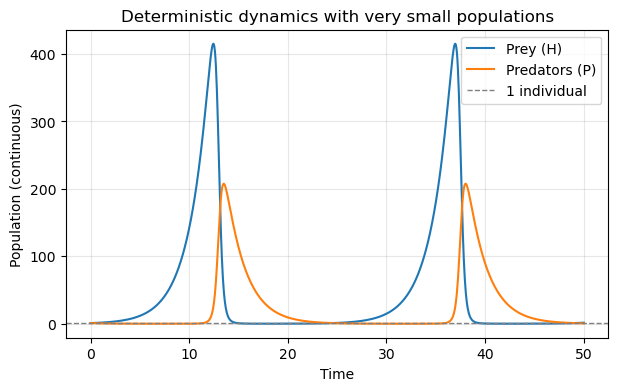

In [8]:
def small_populations():
    # Parameters 
    b, m, r, a = 0.5, 0.5, 0.02, 0.01

    # Very small initial populations
    H0, P0 = 1, 1
    t_max = 50

    t, H, P, H_eq, P_eq = simulate_lv(b, m, r, a, H0, P0, t_max)

    plt.figure(figsize=(7, 4))
    plt.plot(t, H, label="Prey (H)")
    plt.plot(t, P, label="Predators (P)")
    plt.axhline(1, color='gray', linestyle='--', linewidth=1, label='1 individual')

    plt.title("Deterministic dynamics with very small populations")
    plt.xlabel("Time")
    plt.ylabel("Population (continuous)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

small_populations()

#### Example 2 – Perfect, undamped cycles

The deterministic Lotka–Volterra model predicts closed orbits that repeat forever. Even if we change the initial conditions slightly, each trajectory stays on a perfect periodic cycle and never spirals in or out.

This is very unlikely for most of the real-world Predator–Prey systems.

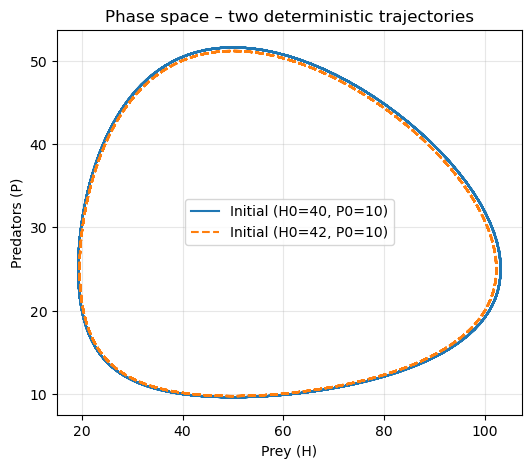

In [9]:
def perfect_cycles():
    b, m, r, a = 0.5, 0.5, 0.02, 0.01
    t_max = 150

    H0_1, P0_1 = 40, 10
    H0_2, P0_2 = 42, 10

    t1, H1, P1, _, _ = simulate_lv(b, m, r, a, H0_1, P0_1, t_max)
    t2, H2, P2, _, _ = simulate_lv(b, m, r, a, H0_2, P0_2, t_max)

    plt.figure(figsize=(6, 5))

    # Phase space: predators vs prey
    plt.plot(H1, P1, label=f"Initial (H0={H0_1}, P0={P0_1})")
    plt.plot(H2, P2, label=f"Initial (H0={H0_2}, P0={P0_2})", linestyle='--')

    plt.title("Phase space – two deterministic trajectories")
    plt.xlabel("Prey (H)")
    plt.ylabel("Predators (P)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

perfect_cycles()

On the other hand, a stochastic model allows us to incorporate randomness, individual-level interactions, and the possibility of extinction. These features often make the behavior of ecological systems fundamentally different from the predictions of the deterministic ODE.

In the next section, we will introduce a ***stochastic simulation approach*** to capture these more realistic dynamics.

### 5. The Stochastic Approach – Gillespie Simulation

#### 5.1 The Framework

***Why Gillespie Algorithm?***

The dynamics of the predator–prey model can be expressed as **discrete random events** with well-defined rates. This fits the assumptions of the Gillespie framework: events (reactions) occur one at a time, each with its own probability rate, and the future evolution depends only on the **current state** (Markov property).

In this view, the Lotka–Volterra system is modeled as a **Continuous-Time Markov Jump Process (CTMJP)**. To apply Gillespie’s algorithm, we rewrite the Lotka–Volterra dynamics as a set of **elementary reactions** between prey $X$ and predators $Y$ with parameters $(\alpha, \beta, \delta)$:

***Reactions***

- **Prey reproduction**
  $$
  R_1:\quad X \xrightarrow{\alpha} X + 1
  $$

- **Predation (prey eaten, predator reproduces)**
  $$
  R_2:\quad X + Y \xrightarrow{\beta} 2Y
  $$

- **Predator death**
  $$
  R_3:\quad Y \xrightarrow{\delta} \varnothing
  $$

***Propensities***

For a given state $(X, Y)$, each reaction $R_\mu$ has a **propensity** $a_\mu(X,Y)$:

$$
\begin{aligned}
a_1(X,Y) &= \alpha X, \\
a_2(X,Y) &= \beta X Y, \\
a_3(X,Y) &= \delta Y.
\end{aligned}
$$

The **total propensity** is

$$
a_0(X,Y) = a_1(X,Y) + a_2(X,Y) + a_3(X,Y).
$$

In the code this is stored in an array `a` of length 4 as:

- `a[1] = a_1`, `a[2] = a_2`, `a[3] = a_3`, and  
- `a[0] = a_0 = a[1] + a[2] + a[3]`.

---

#### 5.2 Implementation of the Gillespie SSA

The stochastic simulation consists of the two fundamental random choices of the Gillespie SSA.

***1. Time to the next event***
Given the current state $(X,Y)$:

1. Compute the propensities $a_1, a_2, a_3$ and the total
   $$
   a_0 = a_1 + a_2 + a_3.
   $$
2. Draw a uniform random number $U_1 \sim \mathrm{Uniform}(0,1)$.
3. Sample the waiting time
   $$
   \tau = -\frac{\ln U_1}{a_0}.
   $$
4. Update the simulation time:
   $$
   t \leftarrow t + \tau.
   $$

In the code this corresponds to:

```python
a = propensities(x, y)
tau = -log(random.random()) / a[0]
time += tau
```

***2. Determining which reaction fires***

1. Draw a second uniform random number $U_2 \sim \mathrm{Uniform}(0,1)$.
2. Compute
   $$
   r^* = U_2 \, a_0.
   $$
3. Choose the reaction according to the cumulative propensities:

```python
r = a[0] * random.random()
cumulative = 0.0
for i in range(1, 4):    # reactions 1, 2, 3
    cumulative += a[i]
    if r < cumulative:
        react = i
        break
```

Mathematically, this implements

$$
\mathbb{P}(\text{next event is } R_\mu \mid X,Y)
= \frac{a_\mu(X,Y)}{a_0(X,Y)}.
$$

***3. State update***

Once reaction $R_\mu$ is chosen, the state is updated:

- $R_1$: $X \rightarrow X + 1$ (prey reproduction)
- $R_2$: $X \rightarrow X - 1,\quad Y \rightarrow Y + 1$ (predation and predator reproduction)
- $R_3$: $Y \rightarrow Y - 1$ (predator death)

In the code:

```python
dx, dy = applyReaction(react)
x += dx
y += dy
```

The algorithm repeats until $t \ge \texttt{timeMax}$ or the number of events exceeds `eventMax`.


In [10]:
# LV Parameters chosen empirically
alpha = 1.0      # Prey birth rate
beta = 0.01       # Predation rate (prey death, predator birth)
delta = 0.75    # Predator death rate

# Simulation parameters
nRun = 20        # Number of independent iterations
timeMax = 55     # Max simulation time
eventMax = 100000 # Max events recorded in single run
seed = 42        # Random seed
timeBin = 0.5    # Time bin for statistics

# Number of reactions
nR = 4           # 3 reactions + 1 slot for total propensity


def propensities(x, y):

    """
    Calculate propensities for Lotka-Volterra reactions:
    1. Prey reproduction: X → X + 1 (rate alpha * X)
    2. Predation: X + Y → Y + Y (rate beta * X * Y)
    3. Predator death: Y → 0 (rate delta * Y)
    
    Returns: list of propensities [a0, a1, a2, a3]
    where a0 = total propensity; a1, a2, a3 = individual reaction rates
    """

    a = [0.0] * nR
    
    # R1
    a[1] = alpha * x
    
    # R2
    a[2] = beta * x * y
    
    # R3
    a[3] = delta * y
    
    # Total propensity
    a[0] = sum(a[1:])
    
    return a


def applyReaction(react):

    """
    Apply reaction to change species counts
    Returns: (dx, dy) changes in prey and predator counts
    """
    
    dx = 0
    dy = 0
    
    if react == 1:        # Prey reproduction
        dx = 1
        dy = 0
    elif react == 2:      # Predation
        dx = -1
        dy = 1
    elif react == 3:      # Predator death
        dx = 0
        dy = -1
    else:
        raise ValueError("Invalid reaction type")
    
    return dx, dy


def randomReaction_linear(a):

    """
    Select reaction based on propensities using linear search.
    a[0] is total propensity, a[1:], individual reactions.
    """

    # If total propensity is zero, system is dead
    if a[0] <= 0:
        return None
    
    r = a[0] * random.random()
    
    # Linear search for reaction
    cumulative = 0.0
    for i in range(1, nR):
        cumulative += a[i]
        if r < cumulative:
            return i
    
    return nR - 1


def lotka_volterra_ode(state, t, alpha, beta, delta):

    """
    Deterministic Lotka-Volterra ODEs for comparison
    """
    
    x, y = state
    dxdt = alpha * x - beta * x * y
    dydt = beta * x * y - delta * y
    return [dxdt, dydt]

In [11]:
# STOCHASTIC SIMULATION

# Initial conditions
x0 = 10  # Initial prey count
y0 = 20  # Initial predator count

random.seed(seed)
np.random.seed(seed)

# Prepare for statistics
nTimeBin = int(timeMax / timeBin) + 1
x_av = np.zeros(nTimeBin)
x_sigma = np.zeros(nTimeBin)
y_av = np.zeros(nTimeBin)
y_sigma = np.zeros(nTimeBin)
z = np.zeros(nTimeBin) 

# Single run storage
time_sr = np.zeros(eventMax)
x_sr = np.zeros(eventMax)
y_sr = np.zeros(eventMax)
phase_x = []
phase_y = []

# Store all runs for statistics
all_runs_x = []
all_runs_y = []
all_runs_t = []

print(f"Running {nRun} Gillespie simulations...")

# Loop over independent runs
for iRun in range(nRun):
    if (iRun + 1) % 10 == 0:
        print(f"  Run {iRun + 1}/{nRun}")
    
    x = x0
    y = y0
    time = 0.0
    iStep = 0
    
    record_single = (iRun == 0)
    
    if record_single:
        time_sr[iStep] = time
        x_sr[iStep] = x
        y_sr[iStep] = y
        phase_x.append(x)
        phase_y.append(y)
    
    # Temporary storage for this run
    run_x = []
    run_y = []
    
    # Gillespie loop
    while time < timeMax and iStep < eventMax - 1:
        # Propensities
        a = propensities(x, y)
        
        # Check if system is dead
        if a[0] <= 0:
            if record_single and 2*iStep+1 < eventMax:
                time_sr[2*iStep+1] = timeMax
                x_sr[2*iStep+1] = x
                y_sr[2*iStep+1] = y
            break
        
        # Draw time
        tau = -log(random.random()) / a[0]
        
        # Draw reaction identity
        react = randomReaction_linear(a)
        if react is None:
            break
        
        # Record state just before reaction (for single run)
        if record_single and 2*iStep+1 < eventMax:
            time_sr[2*iStep+1] = time + tau
            x_sr[2*iStep+1] = x
            y_sr[2*iStep+1] = y
        
        # Apply reaction
        dx, dy = applyReaction(react)
        x += dx
        y += dy
        
        # Update time
        time += tau
        iStep += 1
        
        # Record state after reaction (single run)
        if record_single and 2*iStep < eventMax:
            time_sr[2*iStep] = time
            x_sr[2*iStep] = x
            y_sr[2*iStep] = y
            phase_x.append(x)
            phase_y.append(y)
        
        # For multi-run phase plane
        run_x.append(x)
        run_y.append(y)
        
        # Collect statistics
        iTime = int(time / timeBin)
        if iTime < nTimeBin:
            x_av[iTime] += x
            x_sigma[iTime] += x * x
            y_av[iTime] += y
            y_sigma[iTime] += y * y
            z[iTime] += 1
    
    # Store this run (as numpy arrays)
    all_runs_x.append(np.array(run_x))
    all_runs_y.append(np.array(run_y))

print("The simulation is complete.")

for i in range(nTimeBin):
    if z[i] > 0:
        x_av[i] /= z[i]
        x_sigma[i] = np.sqrt(x_sigma[i] / z[i] - x_av[i] * x_av[i])
        y_av[i] /= z[i]
        y_sigma[i] = np.sqrt(y_sigma[i] / z[i] - y_av[i] * y_av[i])

valid_indices = time_sr <= timeMax
time_sr = time_sr[valid_indices]
x_sr = x_sr[valid_indices]
y_sr = y_sr[valid_indices]

xLabels = np.arange(0.5*timeBin, timeMax+timeBin, timeBin)


Running 20 Gillespie simulations...
  Run 10/20
  Run 20/20
The simulation is complete.


In [12]:
# DETERMINISTIC SOLUTION (ODE) for comparison

t_ode = np.linspace(0, timeMax, 1000)
sol_ode = odeint(lotka_volterra_ode, [x0, y0], t_ode, args=(alpha, beta, delta))
x_ode = sol_ode[:, 0]
y_ode = sol_ode[:, 1]


This is one realization of the Gillespie simulation. The dynamics fluctuate due to intrinsic demographic noise.  

Notice how the populations oscillate but with **variable amplitude and period**, unlike the deterministic ODE.

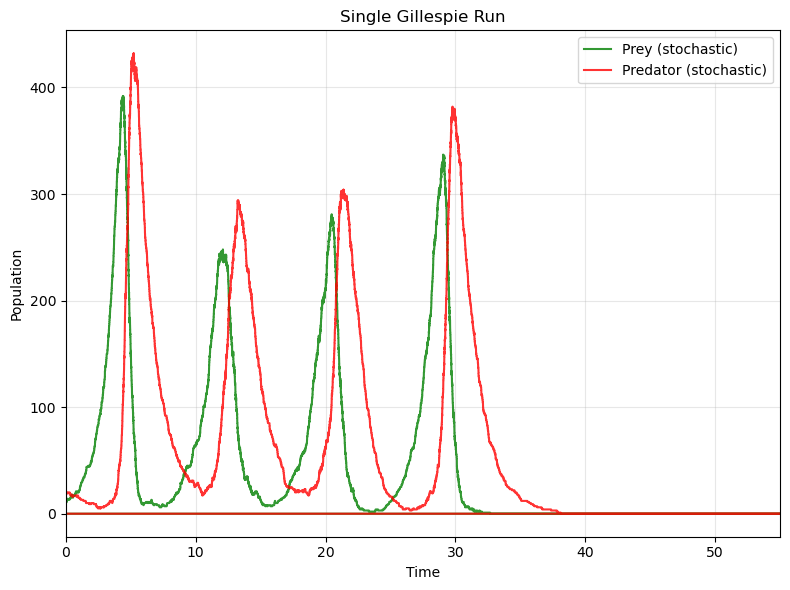

In [13]:
plt.figure(figsize=(8, 6))
plt.plot(time_sr, x_sr, 'g-', label='Prey (stochastic)', alpha=0.8, linewidth=1.5)
plt.plot(time_sr, y_sr, 'r-', label='Predator (stochastic)', alpha=0.8, linewidth=1.5)
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Single Gillespie Run')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, timeMax)
plt.tight_layout()
plt.show()

This plot shows the path of a single stochastic trajectory in the **(prey, predator)** plane.

It does *not* follow a closed orbit like the deterministic system, but instead wanders around the equilibrium.


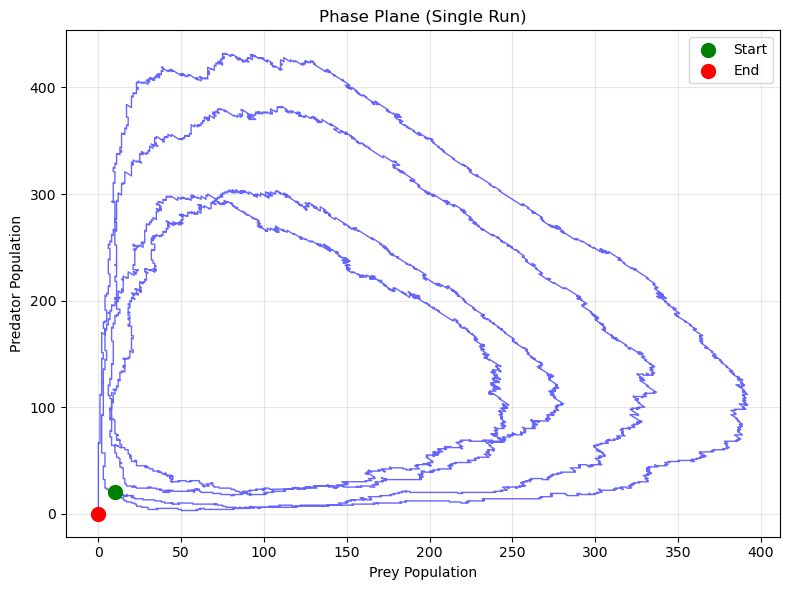

In [14]:
plt.figure(figsize=(8, 6))
plt.plot(x_sr, y_sr, 'b-', alpha=0.6, linewidth=1)
plt.scatter(x_sr[0], y_sr[0], color='green', s=100, label='Start', zorder=5)
plt.scatter(x_sr[-1], y_sr[-1], color='red', s=100, label='End', zorder=5)
plt.xlabel('Prey Population')
plt.ylabel('Predator Population')
plt.title('Phase Plane (Single Run)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Here we overlay several independent Gillespie simulations.

Each trajectory experiences different timing and sequence of events, illustrating how **stochastic effects break the symmetry** of the deterministic orbit.

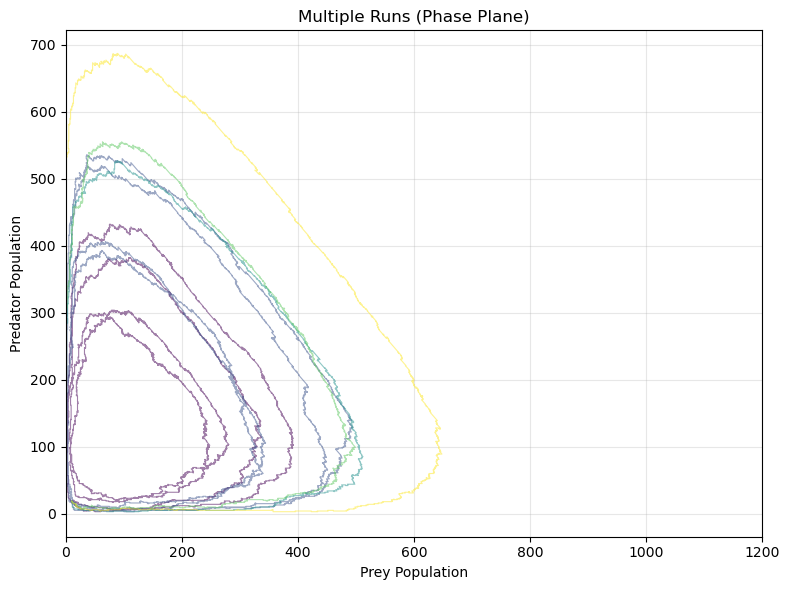

In [15]:
plt.figure(figsize=(8, 6))

num_runs_to_show = min(5, nRun)
colors = plt.cm.viridis(np.linspace(0, 1, num_runs_to_show))

for i in range(num_runs_to_show):
    plt.plot(all_runs_x[i], all_runs_y[i], color=colors[i], alpha=0.5, linewidth=0.8)

plt.xlim(0, 1200)

plt.xlabel('Prey Population')
plt.ylabel('Predator Population')
plt.title('Multiple Runs (Phase Plane)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Averaging across runs reduces noise, recovering a curve that approximates the deterministic ODE.

This demonstrates:

- Individual paths ≠ deterministic solution  
- Average of many stochastic paths ≈ deterministic solution  


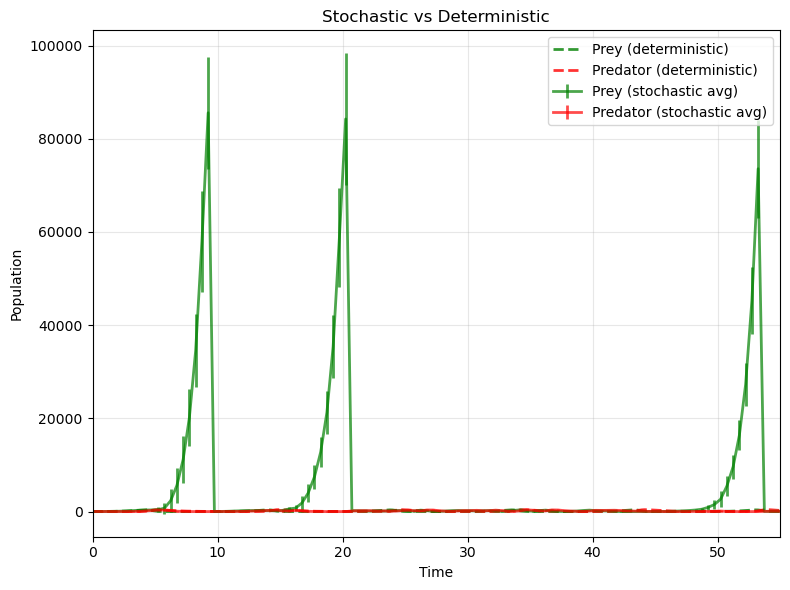

In [16]:
plt.figure(figsize=(8, 6))

if nRun > 1:
    plt.errorbar(xLabels, x_av, yerr=x_sigma,
                 label='Prey (stochastic avg)', 
                 color='green', alpha=0.7, fmt='-', linewidth=2)
    plt.errorbar(xLabels, y_av, yerr=y_sigma,
                 label='Predator (stochastic avg)', 
                 color='red', alpha=0.7, fmt='-', linewidth=2)
else:
    plt.plot(time_sr, x_sr, 'g-', label='Prey (stochastic)', linewidth=2)
    plt.plot(time_sr, y_sr, 'r-', label='Predator (stochastic)', linewidth=2)

plt.plot(t_ode, x_ode, 'g--', label='Prey (deterministic)', linewidth=2, alpha=0.8)
plt.plot(t_ode, y_ode, 'r--', label='Predator (deterministic)', linewidth=2, alpha=0.8)

plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Stochastic vs Deterministic')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, timeMax)
plt.tight_layout()
plt.show()


Because the stochastic model allows populations to hit zero, extinction becomes possible.

We run 1000 short simulations and record whether:

- Prey go extinct  
- Predators go extinct  
- Both go extinct  
- Both survive  

Over long enough times, we can observe that extinction probability approaches 1 due to demographic noise.


In [17]:
# EXTINCTION ANALYSIS

print("EXTINCTION ANALYSIS")

n_extinction_sims = 1000
time_ext_max = 100
extinction_counts = {"prey": 0, "predator": 0, "both": 0}

print(f"\nRunning {n_extinction_sims} simulations for extinction analysis:")

for i in range(n_extinction_sims):
    x = x0
    y = y0
    time = 0.0
    
    while time < time_ext_max:
        a = propensities(x, y)
        if a[0] <= 0:
            break
        
        tau = -log(random.random()) / a[0]
        react = randomReaction_linear(a)
        
        if react == 1:      # Prey reproduction
            x += 1
        elif react == 2:    # Predation
            x -= 1
            y += 1
        elif react == 3:    # Predator death
            y -= 1
        
        time += tau
        
        # Check for extinction
        if x <= 0 and y <= 0:
            extinction_counts["both"] += 1
            break
        elif x <= 0:
            extinction_counts["prey"] += 1
            break
        elif y <= 0:
            extinction_counts["predator"] += 1
            break
    
    if (i + 1) % 100 == 0:
        print(f"  Completed {i + 1}/{n_extinction_sims}")

print(f"\nExtinction probabilities by time {time_ext_max}:")
print(f"  Prey extinction: {extinction_counts['prey']/n_extinction_sims:.3f}")
print(f"  Predator extinction: {extinction_counts['predator']/n_extinction_sims:.3f}")


EXTINCTION ANALYSIS

Running 1000 simulations for extinction analysis:
  Completed 100/1000
  Completed 200/1000
  Completed 300/1000
  Completed 400/1000
  Completed 500/1000
  Completed 600/1000
  Completed 700/1000
  Completed 800/1000
  Completed 900/1000
  Completed 1000/1000

Extinction probabilities by time 100:
  Prey extinction: 0.797
  Predator extinction: 0.170


### 6. Performance improvement for the Stohcastic Approach

Gillespie’s SSA simulates one reaction event at a time. Each step has two main costs:

1. computing all propensities $ a_1, \dots, a_M $ and their sum $ a_0 $;
2. choosing which reaction fires, with probability $ a_\mu / a_0 $.


In the basic implementation, the next reaction is chosen by:

- drawing a uniform random number $ r \in [0, a_0) $;  
- linearly scanning the reactions in a fixed order $ 1, 2, 3, \dots $ until the cumulative sum exceeds $ r $.

The expected number of comparisons is:

$$
\mathbb{E}[\text{comparisons}] 
= \sum_{\mu=1}^M \mu \cdot \mathbb{P}(\text{reaction } \mu),
$$

so if a "rare" reaction is always checked first, the algorithm wastes time.

---

***Dynamic ordering***

Dynamic ordering is a simple idea to reduce this expected cost:

- At each step, order reactions by their current propensity, so that reactions with larger $ a_\mu $ are checked first.

This does **not** change the probabilities.  
Reordering the terms in the cumulative sum preserves

$$
\mathbb{P}(\text{pick reaction } \mu)
= \frac{a_\mu}{a_0},
$$

so the algorithm is still an **exact Gillespie SSA**, not an approximation.  

---

***Implementation:***

We adopt the following simple dynamic-ordering strategy:

1. after computing the propensities, we build a list  
   $$
   [(a_1, 1), (a_2, 2), \dots];
   $$
2. we sort this list in **descending** order of $ a_i $;
3. we perform the usual cumulative-sum selection on the reordered list.

For our Lotka–Volterra model we only have three reactions, so:

- the theoretical speedup is small,  
- the Python `sort()` overhead may even dominate.

However, this implementation demonstrates the **same optimization principle** used in much larger stochastic chemical networks, where:

- the number of reactions $ M $ is large, and  
- a few reactions often dominate the total propensity.

In such cases, dynamic ordering significantly reduces the average number of comparisons per step and therefore the total runtime of the SSA, all while preserving the exact stochastic dynamics.

In [18]:
# new reaction selector with dynamic ordering

def randomReaction_dynamic(a):

    """
    Improved reaction selector:
    dynamically orders reactions by propensity (highest first)
    and then performs the usual cumulative selection.

    This keeps P(reaction μ) = a[μ] / a[0] exactly,
    so it is still an exact Gillespie SSA.
    """

    if a[0] <= 0:
        return None

    r = a[0] * random.random()

    # Build list of (propensity, index) for reactions with positive propensity
    reactions = [(a[i], i) for i in range(1, nR) if a[i] > 0.0]
    if not reactions:
        return None

    # Dynamic ordering: sort highest propensity first
    reactions.sort(key=lambda pair: pair[0], reverse=True)

    cumulative = 0.0
    for ai, idx in reactions:
        cumulative += ai
        if r < cumulative:
            return idx

    return reactions[-1][1]

In [19]:
def run_gillespie(selector_func):

    """
    Run the Lotka-Volterra Gillespie SSA using the given
    reaction-selection function (randomReaction_linear or randomReaction_dynamic).

    Returns:
        x_av, y_av, x_sigma, y_sigma, x_sr, y_sr, time_sr
    (same structure as your original code)
    """

    random.seed(seed)
    np.random.seed(seed)

    # Initial conditions
    x0 = 10
    y0 = 20

    # Prepare for statistics
    nTimeBin = int(timeMax / timeBin) + 1
    x_av = np.zeros(nTimeBin)
    x_sigma = np.zeros(nTimeBin)
    y_av = np.zeros(nTimeBin)
    y_sigma = np.zeros(nTimeBin)
    z = np.zeros(nTimeBin)  # counts per bin

    # Single run storage (first run)
    time_sr = np.zeros(eventMax)
    x_sr = np.zeros(eventMax)
    y_sr = np.zeros(eventMax)
    phase_x = []
    phase_y = []

    # Loop over independent runs
    for iRun in range(nRun):
        x = x0
        y = y0
        time = 0.0
        iStep = 0

        record_single = (iRun == 0)

        if record_single:
            time_sr[iStep] = time
            x_sr[iStep] = x
            y_sr[iStep] = y
            phase_x.append(x)
            phase_y.append(y)

        # Gillespie loop
        while time < timeMax and iStep < eventMax - 1:
            a = propensities(x, y)

            # System dead?
            if a[0] <= 0:
                if record_single and 2 * iStep + 1 < eventMax:
                    time_sr[2 * iStep + 1] = timeMax
                    x_sr[2 * iStep + 1] = x
                    y_sr[2 * iStep + 1] = y
                break

            # Draw time
            tau = -log(random.random()) / a[0]

            # Draw reaction identity using the chosen selector
            react = selector_func(a)
            if react is None:
                break

            # Record state just before reaction (single run)
            if record_single and 2 * iStep + 1 < eventMax:
                time_sr[2 * iStep + 1] = time + tau
                x_sr[2 * iStep + 1] = x
                y_sr[2 * iStep + 1] = y

            # Apply reaction
            dx, dy = applyReaction(react)
            x += dx
            y += dy

            # Update time and step
            time += tau
            iStep += 1

            # Record state after reaction (single run)
            if record_single and 2 * iStep < eventMax:
                time_sr[2 * iStep] = time
                x_sr[2 * iStep] = x
                y_sr[2 * iStep] = y
                phase_x.append(x)
                phase_y.append(y)

            # Collect statistics
            iTime = int(time / timeBin)
            if iTime < nTimeBin:
                x_av[iTime] += x
                x_sigma[iTime] += x * x
                y_av[iTime] += y
                y_sigma[iTime] += y * y
                z[iTime] += 1

    # Normalize statistics
    for i in range(len(z)):
        if z[i] > 0:
            x_av[i] /= z[i]
            x_sigma[i] = np.sqrt(x_sigma[i] / z[i] - x_av[i] ** 2)
            y_av[i] /= z[i]
            y_sigma[i] = np.sqrt(y_sigma[i] / z[i] - y_av[i] ** 2)

    # Cut single-run arrays to valid times
    valid = time_sr <= timeMax
    time_sr = time_sr[valid]
    x_sr = x_sr[valid]
    y_sr = y_sr[valid]

    return x_av, y_av, x_sigma, y_sigma, x_sr, y_sr, time_sr

In [21]:
import time

# Run with original (linear) selector
t0 = time.perf_counter()
x_av_lin, y_av_lin, x_sig_lin, y_sig_lin, x_sr_lin, y_sr_lin, t_sr_lin = run_gillespie(randomReaction_linear)
t1 = time.perf_counter()

# Run with dynamic ordering selector
t2 = time.perf_counter()
x_av_dyn, y_av_dyn, x_sig_dyn, y_sig_dyn, x_sr_dyn, y_sr_dyn, t_sr_dyn = run_gillespie(randomReaction_dynamic)
t3 = time.perf_counter()

print(f"Linear selector runtime:  {t1 - t0:.4f} s")
print(f"Dynamic selector runtime: {t3 - t2:.4f} s")

Linear selector runtime:  0.6975 s
Dynamic selector runtime: 0.5121 s


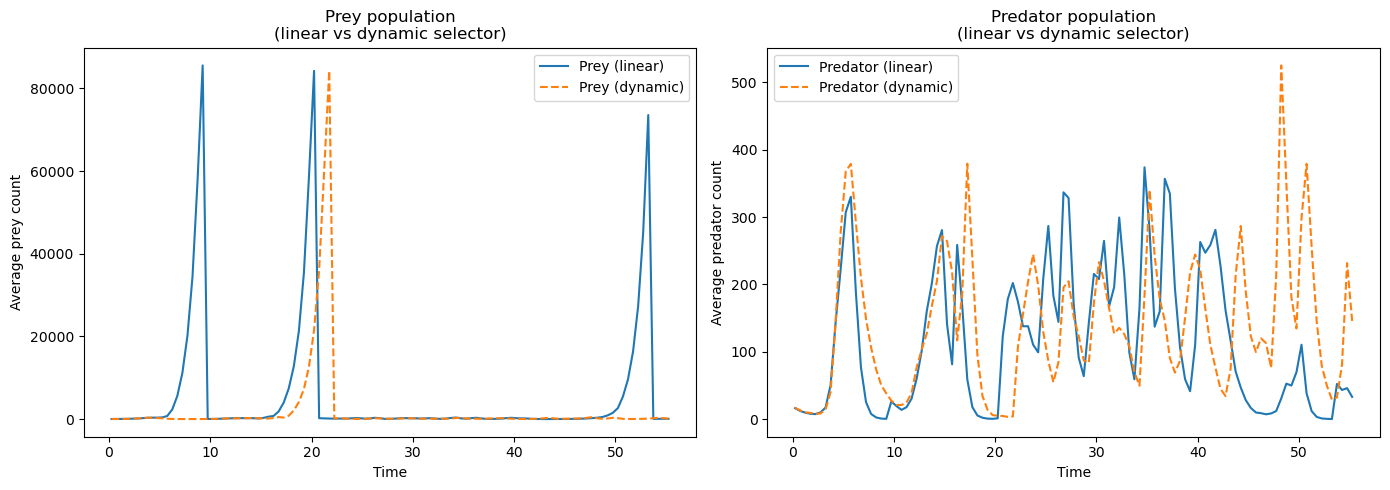

In [25]:
time_bins = np.arange(0.5 * timeBin, timeMax + timeBin, timeBin)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Prey
axes[0].plot(time_bins, x_av_lin, label="Prey (linear)")
axes[0].plot(time_bins, x_av_dyn, '--', label="Prey (dynamic)")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Average prey count")
axes[0].set_title("Prey population\n(linear vs dynamic selector)")
axes[0].legend()

# Predator
axes[1].plot(time_bins, y_av_lin, label="Predator (linear)")
axes[1].plot(time_bins, y_av_dyn, '--', label="Predator (dynamic)")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Average predator count")
axes[1].set_title("Predator population\n(linear vs dynamic selector)")
axes[1].legend()

plt.tight_layout()
plt.show()


The **average trajectories** of prey and predator populations obtained with the original SSA and with the dynamically ordered SSA are practically indistinguishable. This confirms that the optimization does **not** change the stochastic model: both algorithms still implement Gillespie’s SSA exactly.

For our **Lotka–Volterra example**, we can observe that the wall-clock runtimes of the two implementations are very similar.

### 7. Conclusions

The stochastic simulation framework provides a more faithful representation of the Lotka–Volterra dynamics than the corresponding deterministic ODE model, particularly in situations where population sizes are low or reaction events occur irregularly. 

Whereas the ODE formulation yields smooth trajectories reflecting mean-field behavior, the Gillespie SSA captures the inherent discreteness of individuals and the random timing of interaction events. This allows the stochastic approach to reproduce essential phenomena, such as variability in oscillation amplitudes, noise-driven deviations from the mean trajectory, and species extinction events. In consequence, the stochastic method offers a more accurate and informative characterization of biological systems whose dynamics are shaped by demographic noise and probabilistic interactions.